### Importing the libs

In [22]:
!pip install MiniSom

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Importing the dataset

In [24]:
dataset = pd.read_csv('data/Credit_Card_Applications.csv')
dataset

,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class
0,15776156,1,22.08,11.460,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,15739548,0,22.67,7.000,2,8,4,0.165,0,0,0,0,2,160,1,0
2,15662854,0,29.58,1.750,1,4,4,1.250,0,0,0,1,2,280,1,0
3,15687688,0,21.67,11.500,1,5,3,0.000,1,1,11,1,2,0,1,1
4,15715750,1,20.17,8.170,2,6,4,1.960,1,1,14,0,2,60,159,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,15808223,1,31.57,10.500,2,14,4,6.500,1,0,0,0,2,0,1,1
686,15769980,1,20.67,0.415,2,8,4,0.125,0,0,0,0,2,0,45,0
687,15675450,0,18.83,9.540,2,6,4,0.085,1,0,0,0,2,100,1,1
688,15776494,0,27.42,14.500,2,14,8,3.085,1,1,1,0,2,120,12,1


In [25]:
X = dataset.iloc[:, :-1].values
X

array([[1.5776156e+07, 1.0000000e+00, 2.2080000e+01, ..., 2.0000000e+00,
        1.0000000e+02, 1.2130000e+03],
       [1.5739548e+07, 0.0000000e+00, 2.2670000e+01, ..., 2.0000000e+00,
        1.6000000e+02, 1.0000000e+00],
       [1.5662854e+07, 0.0000000e+00, 2.9580000e+01, ..., 2.0000000e+00,
        2.8000000e+02, 1.0000000e+00],
       ...,
       [1.5675450e+07, 0.0000000e+00, 1.8830000e+01, ..., 2.0000000e+00,
        1.0000000e+02, 1.0000000e+00],
       [1.5776494e+07, 0.0000000e+00, 2.7420000e+01, ..., 2.0000000e+00,
        1.2000000e+02, 1.2000000e+01],
       [1.5592412e+07, 1.0000000e+00, 4.1000000e+01, ..., 1.0000000e+00,
        5.6000000e+02, 1.0000000e+00]])

In [26]:
y = dataset.iloc[:, -1].values
y

array([0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,

### Feature Scaling

In [27]:
from sklearn.preprocessing import MinMaxScaler

In [28]:
sc = MinMaxScaler(feature_range=(0,1))
X = sc.fit_transform(X)

In [29]:
# Train the SOM

In [30]:
from minisom import MiniSom

In [31]:
som = MiniSom(x=10, y=10, input_len= 15, sigma= 1.0, learning_rate = 0.5)
som.random_weights_init(X)
som.train_random(data = X, num_iteration = 100)

In [32]:
from pylab import bone, pcolor, colorbar, plot, show

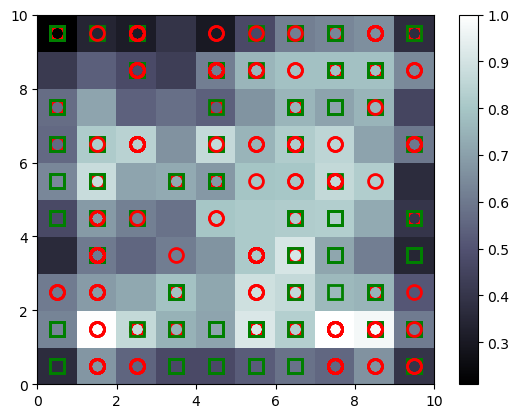

In [33]:
bone()
pcolor(som.distance_map().T)
colorbar()
markers = ['o', 's']
colors = ['r', 'g']
for i, x in enumerate(X):
    w = som.winner(x)
    plot(w[0] + 0.5,
         w[1] + 0.5,
         markers[y[i]],
         markeredgecolor = colors[y[i]],
         markerfacecolor = 'None',
         markersize = 10,
         markeredgewidth = 2)
show()

### Finding the frauds

In [34]:
mappings = som.win_map(X)
frauds = np.concatenate((mappings[(6,8)], mappings[(5,1)]), axis = 0)
frauds = sc.inverse_transform(frauds)

In [35]:
# Fraud clients:
print('Fraud Customer IDs')
for i in frauds[:, 0]:
  print(int(i))

Fraud Customer IDs
15692718
15677395
15786237
15767358
15671014
15740487
15811742
15702571
15715907
15768342
15748532
15689692
15672357
15788634
